# Simulation des données

Dans ce notebook, nous simulons des données pour ensuite les proposer au filtre. Nous nous inspirons du papier de Dureau et al. (2013) concernant la paramétrisation. Nous générons un fichier en sortie, <tt> data_with_beta.csv </tt>, qui contient des valeurs simulées pour l'incidence et les vraies valeurs de $\beta_t$ pour 50 pas de temps.

In [1]:
# Importation des libraires
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import random
import sdeint
import math
import statistics as stat

# Fichiers auxiliaires
% run 'utilities.py'

## Simulation du système d'équations, comparaison avec les données source

On simule dans un premier temps une trajectoire. Les paramètres sont ajustés pour "mimer" les données.
NB. Pour les graphes, il peut être nécessaire d'exéuter plusieurs fois la cellule pour que les dimensions du plot soient correctes.

In [2]:
# Simulation des données

np.random.seed(22) # Pour la reprocucibilité

# Paramètres
mu, sigma, gamma = 0., 0.2, 4.

# Variance pour le BM
sigma_x = .5

# Vecteur temporel
t = np.linspace(0, 50, 10000)

# Conditions initiales
S0, E0, I0, R0 = 0.9, 0.0, 0.1, 0.
y0 = np.array([S0, E0, I0, R0, mu])


def simulate_stochastic_SEIR_model(y, t):
    # Déballer les valeurs initiales
    # Partie déterministe
    S = y[0]
    E = y[1]
    I = y[2]
    R = y[3]
    # Partie stochastique
    x = y[4]
    
    # Population totale
    N = S + E + I + R
    
    # Equations du modèle
    dS_dt = - math.exp(y[4]) * S * I / N
    dE_dt = math.exp(y[4]) * S * I / N - gamma * E
    dI_dt = gamma * E - sigma * I
    dR_dt = sigma * I
    dx_dt = mu
    return np.array([dS_dt, dE_dt, dI_dt, dR_dt, dx_dt])


# Partie stochastique
def BM(y, t):
    return np.diag([0, 0, 0, 0, sigma_x])

# Résolution
result = sdeint.itoEuler(simulate_stochastic_SEIR_model, BM, y0, t)

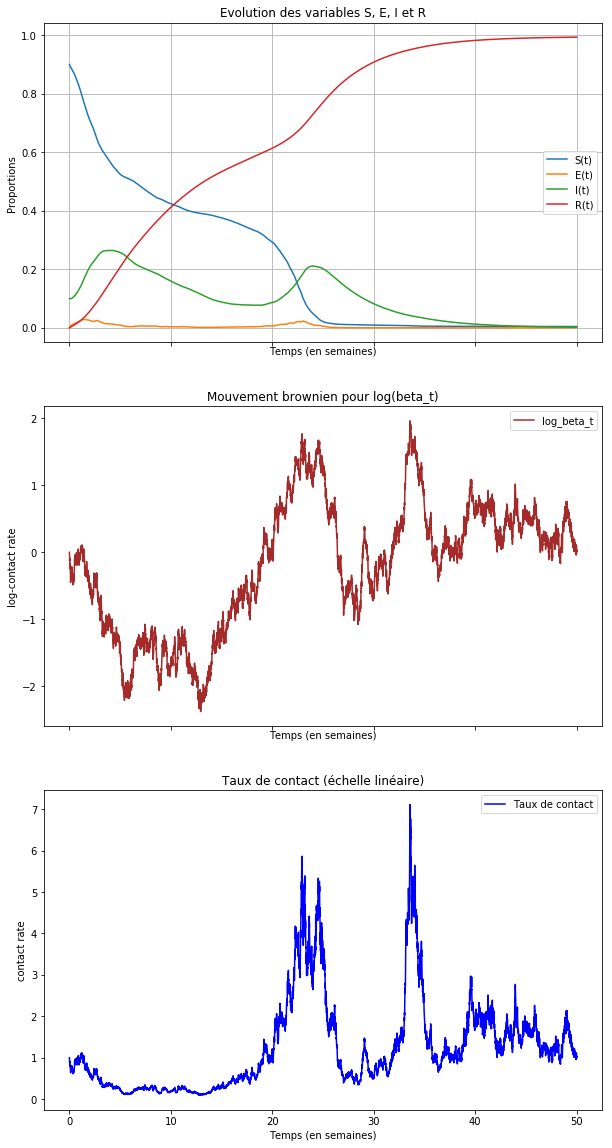

In [4]:
# Affichage de la trajectoire simulée

plot_realisation(result, t, {}, {}, {}, (10,20))

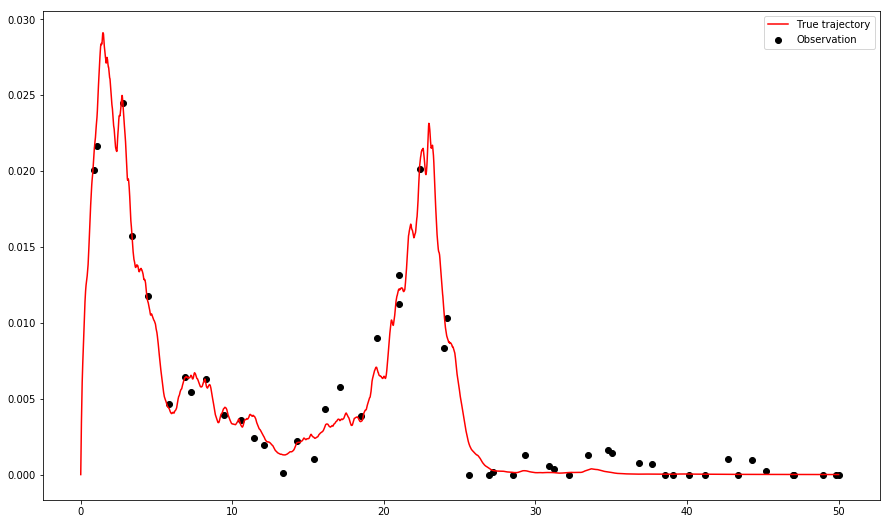

In [6]:
# Extraction le la courbe des infectieux

E_t = result[:,1]
vals, indices = generate_noisy_incidence(E_t, .001, 1, t) # Paramètres : 0.001 bruit d'observation
                                                          # 1 : taille des "boites" de la discrétisation

plt.plot(t, E_t, c = "red", label = "True trajectory")
plt.scatter(t[indices], vals, c = 'black', label = "Observation")
plt.legend()

plt.rcParams["figure.figsize"] = (15,9)
plt.show()

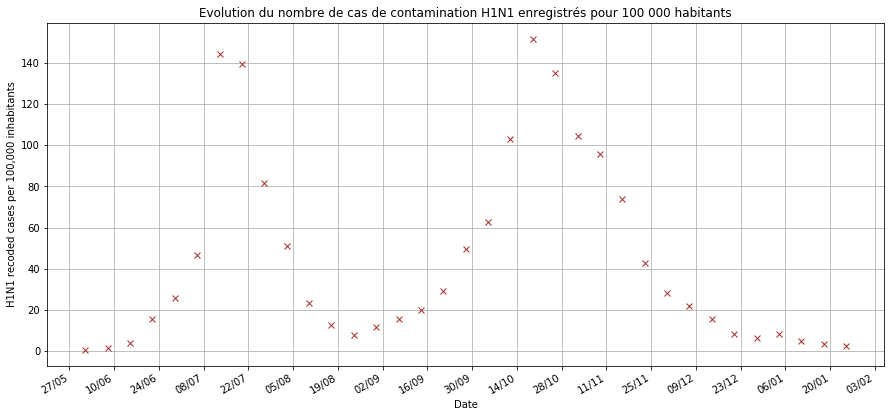

In [7]:
# Importation des vraies données pour comparaison 

# Donnée source
data = pd.read_csv("raw_data.csv")

# Convertir la date au format datetime
dates = data.date.values
data["date"] = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in dates]

# Plot

# Paramètres visuels
kwargs = {'alpha' : 0.99, 'c': 'brown', 'marker' : 'x'}

# Visualisation
fig, ax = plt.subplots(figsize=(15, 7))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.grid()
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=14))
plt.plot_date(data.date,data.London__HPA__inc, **kwargs)
plt.gcf().autofmt_xdate()
plt.xlabel("Date")
plt.ylabel("H1N1 recoded cases per 100,000 inhabitants")
plt.title("Evolution du nombre de cas de contamination H1N1 enregistrés pour 100 000 habitants")

plt.show()

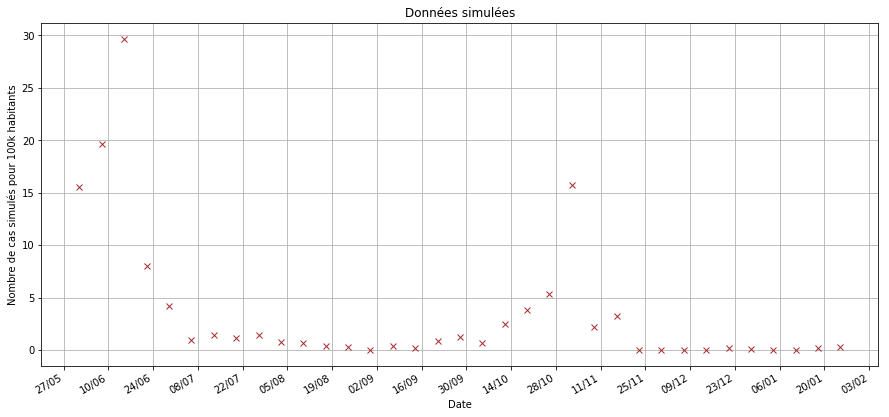

In [8]:
# Affichage les données mimées

# Changement d'échelle pour coller un peu mieux aux observations réelles

vals =[ math.exp(i*100)**1.4 - 1 for i in vals]

# Stocker ces valeurs dans une DataFrame
fake_data = pd.DataFrame()
fake_data["date"] = data.date
fake_data["incidence"] = vals[:35] # On retient les 35 premiers points pour matcher avec les vraies données

# Plot

# Paramètres visuels
kwargs = {'alpha' : 0.99, 'c': 'brown', 'marker' : 'x'}

# Visualisation
fig, ax = plt.subplots(figsize=(15, 7))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.grid()
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=14))
plt.plot_date(fake_data.date,fake_data.incidence, **kwargs)
plt.gcf().autofmt_xdate()
plt.xlabel("Date")
plt.ylabel("Nombre de cas simulés pour 100k habitants")
plt.title("Données simulées")

plt.show()

## Simulation de données d'entrainement

Pour la suite, nous générons un jeu de données non nécessairement réaliste mais suivant les indications de l'article. Nous fixons le bruit d'observation à $\tau_y = 0.05$ et la variance de la marche aléatoire pour $x_t$ (qui approxime le processus de diffusion) à $\sigma_x = 0.07$.

Nous exportons les données ainsi simulées dans le fichier <tt> data_with_beta.csv</tt>.

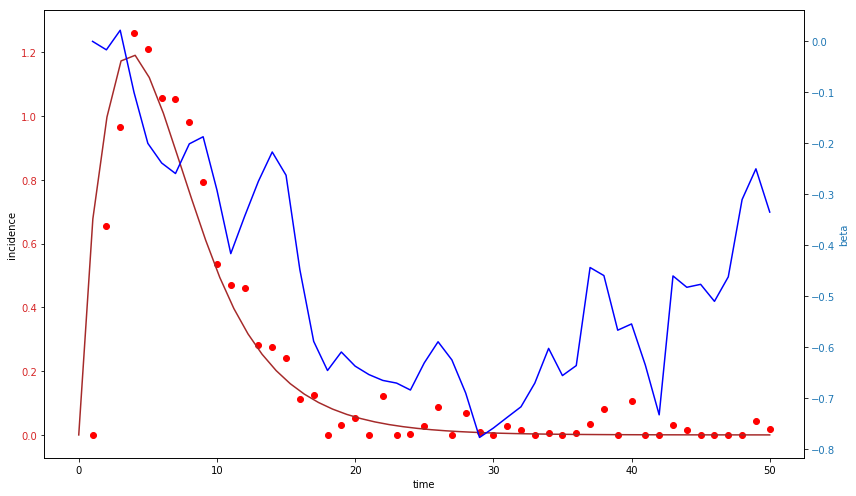

In [10]:
# Ajout d'une option pour avoir It et la trajectoire de beta dans un csv.
# Les points pour beta sont donnés avec la même fréquence que les valeurs de I_t

## Simuler une trajectoire

import sdeint
import numpy as np
import math

# Simulation des données
np.random.seed(42)

# Paramètres
mu, sigma, gamma = 0., 0.01, .2

# Variance pour le BM
sigma_x = .07

# Vecteur temporel
t = np.linspace(0, 50, 50) # Pour passer à une RW, 50 pas de temps uniquement

# Conditions initiales
S0, E0, I0, R0 = 0.7, 0.0, 0.3, 0.
y0 = 10**.5 * np.array( [S0, E0, I0, R0, mu])


def simulate_stochastic_SEIR_model(y, t):
    # Déballer les valeurs initiales
    # Partie déterministe
    S = y[0]
    E = y[1]
    I = y[2]
    R = y[3]
    # Partie stochastique
    x = y[4]
    
    # Population totale
    N = S + E + I + R
    
    # Equations du modèle
    dS_dt = - math.exp(y[4]) * S * I / N
    dE_dt = math.exp(y[4]) * S * I / N - gamma * E
    dI_dt = gamma * E - sigma * I
    dR_dt = sigma * I
    dx_dt = mu
    return np.array([dS_dt, dE_dt, dI_dt, dR_dt, dx_dt])


# Partie stochastique
def BM(y, t):
    return np.diag([0, 0, 0, 0, sigma_x])

# Résolution
result = sdeint.itoEuler(simulate_stochastic_SEIR_model, BM, y0, t)

## Bruiter les observations

# Pour tau = .05

# Génération de fausses données

# Observations aléatoires pour E_t (on prend le nombre de nouveaux cas, pas nécessairement infectieux.)
E_t = result[:,1]
vals, indices = generate_noisy_incidence(E_t, .05, 1, t) # Pour tau = .05

## Stocker les valeur et beta dans une dataframe
fake_data = pd.DataFrame()
fake_data["date"] = range(1,len(vals)+1)
fake_data["incidence"] = vals
fake_data["true_beta"] = result[:,4]

fake_data.to_csv("data_with_beta.csv", header = True)

# Afficher sur un plt la trajectoire de beta, les valeurs et la vraie incidence :

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time')
ax1.set_ylabel('incidence')
ax1.scatter(fake_data["date"], fake_data["incidence"], c = "red")
ax1.plot(t, E_t, c = "brown")
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() 

color = 'tab:blue'
ax2.set_ylabel('beta', color=color)
ax2.plot(fake_data["date"], fake_data["true_beta"], c = "blue")
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.rcParams["figure.figsize"] = (12,7)
plt.savefig('generated_data.png')
plt.show()